In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')


np.random.seed(42)
n_customers = 10000


data = {
    'recency': np.random.exponential(30, n_customers),  # Days since last purchase
    'frequency': np.random.poisson(8, n_customers),     # Purchase frequency
    'monetary': np.random.lognormal(5, 1, n_customers), # Total spending
    'avg_order_value': np.random.gamma(2, 50, n_customers),
    'days_as_customer': np.random.uniform(1, 1000, n_customers),
    'support_tickets': np.random.poisson(2, n_customers)
}

df = pd.DataFrame(data)

df['clv_estimate'] = df['monetary'] * (df['frequency'] / df['recency'].clip(1))
df['engagement_score'] = df['frequency'] / df['days_as_customer'] * 365

print("E-commerce Customer Dataset:")
print(df.describe())

E-commerce Customer Dataset:
            recency     frequency      monetary  avg_order_value  \
count  10000.000000  10000.000000  10000.000000     10000.000000   
mean      29.324969      8.010300    245.112519        98.867292   
std       29.232141      2.815739    317.175138        69.950641   
min        0.000349      0.000000      2.960311         0.133092   
25%        8.483975      6.000000     75.031121        48.082871   
50%       20.349449      8.000000    149.894168        83.645417   
75%       40.412949     10.000000    292.981491       131.392623   
max      245.173368     21.000000   5975.965641       792.407034   

       days_as_customer  support_tickets  clv_estimate  engagement_score  
count      10000.000000      10000.00000  10000.000000      10000.000000  
mean         507.290253          2.01540    248.649946         18.561460  
std          288.131011          1.41745    722.472378         85.643640  
min            1.036549          0.00000      0.000000    

In [2]:
scaler = StandardScaler()

In [3]:
features = ['recency', 'frequency', 'monetary', 'avg_order_value', 'clv_estimate', 'engagement_score']

In [4]:
X_scaled = scaler.fit_transform(df[features])

In [6]:
X_scaled

array([[-0.52160696, -0.71398679,  0.01387513, -0.10011544, -0.19698422,
        -0.12952303],
       [ 2.08611894,  0.35150611, -0.47961557, -0.82074613, -0.331353  ,
        -0.15054473],
       [ 0.34817535, -1.42431538, -0.44112751, -1.12937679, -0.32943658,
        -0.19269473],
       ...,
       [ 2.00590804,  0.35150611, -0.51343312,  0.68298353, -0.3325301 ,
        -0.15238435],
       [-0.48324358,  0.35150611, -0.39988046, -0.64990946, -0.24723169,
        -0.10612623],
       [-0.75198085, -0.00365819,  0.08143693, -0.46140758,  0.06435231,
         0.47459537]])

In [9]:
def find_optimal_k(X, max_k=15):
    inertias = []
    silhouette_scores = []
    K_range = range(2, max_k+1)
    
    for k in K_range:
            kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
            kmeans.fit(X)
            inertias.append(kmeans.inertia_)
            silhouette_scores.append(silhouette_score(X, kmeans.labels_))
    return K_range, inertias, silhouette_scores


In [10]:
K_range, inertias, silhouette_scores = find_optimal_k(X_scaled)

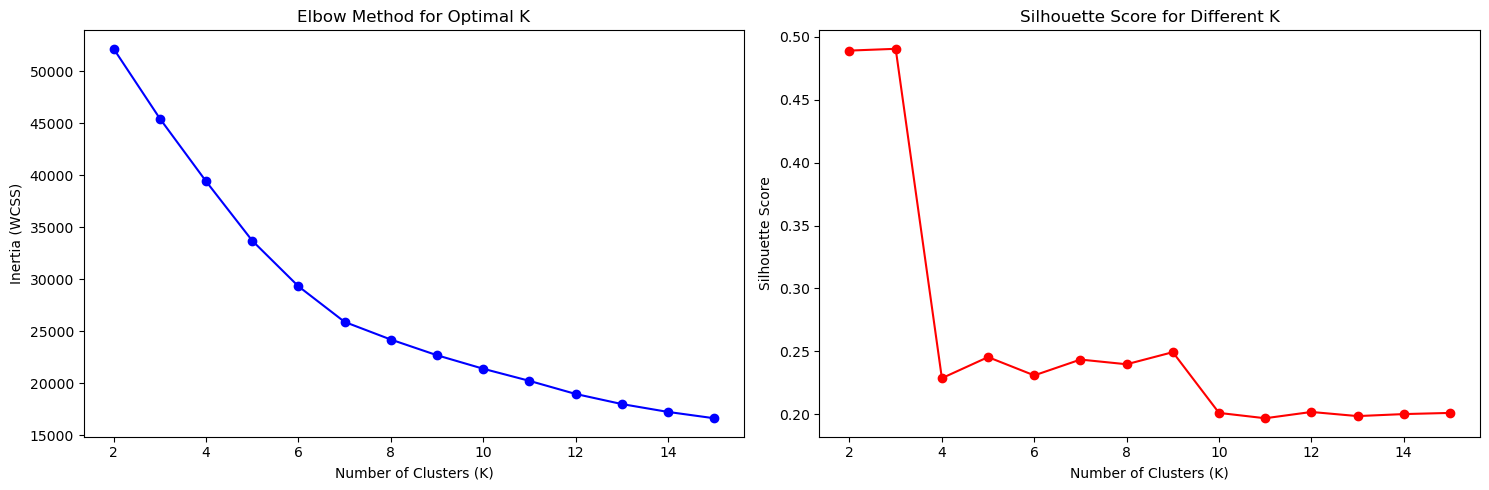

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(K_range, inertias, 'bo-')
ax1.set_title('Elbow Method for Optimal K')
ax1.set_xlabel('Number of Clusters (K)')
ax1.set_ylabel('Inertia (WCSS)')


ax2.plot(K_range, silhouette_scores, 'ro-')
ax2.set_title('Silhouette Score for Different K')
ax2.set_xlabel('Number of Clusters (K)')
ax2.set_ylabel('Silhouette Score')

plt.tight_layout()
plt.show()



In [13]:
optimal_k = K_range[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters: {optimal_k}")

Optimal number of clusters: 3


In [14]:
final_kmeans = KMeans(
    n_clusters=optimal_k, 
    init='k-means++',
    n_init=10,
    random_state=42
)

In [15]:
clusters = final_kmeans.fit_predict(X_scaled)
df['cluster'] = clusters

In [16]:
print("\n=== CUSTOMER SEGMENT ANALYSIS ===")
cluster_analysis = df.groupby('cluster')[features].mean()
cluster_sizes = df['cluster'].value_counts().sort_index()

for cluster in range(optimal_k):
    size = cluster_sizes[cluster]
    print(f"\n🏷️ Cluster {cluster} ({size} customers, {size/len(df)*100:.1f}%):")
    
    recency = cluster_analysis.loc[cluster, 'recency']
    frequency = cluster_analysis.loc[cluster, 'frequency']
    monetary = cluster_analysis.loc[cluster, 'monetary']
    
    if recency < 15 and frequency > 10:
        segment_name = "🌟 VIP Customers"
    elif monetary > 1000 and frequency > 5:
        segment_name = "💎 High-Value"
    elif recency > 60:
        segment_name = "😴 At-Risk"
    elif frequency < 3:
        segment_name = "👶 New/Occasional"
    else:
        segment_name = "🔄 Regular Customers"
    
    print(f"   Segment: {segment_name}")
    print(f"   Avg Recency: {recency:.1f} days")
    print(f"   Avg Frequency: {frequency:.1f} purchases")
    print(f"   Avg Monetary: ${monetary:.0f}")


=== CUSTOMER SEGMENT ANALYSIS ===

🏷️ Cluster 0 (9343 customers, 93.4%):
   Segment: 🔄 Regular Customers
   Avg Recency: 30.3 days
   Avg Frequency: 8.0 purchases
   Avg Monetary: $192

🏷️ Cluster 1 (625 customers, 6.2%):
   Segment: 💎 High-Value
   Avg Recency: 14.7 days
   Avg Frequency: 8.7 purchases
   Avg Monetary: $1039

🏷️ Cluster 2 (32 customers, 0.3%):
   Segment: 🔄 Regular Customers
   Avg Recency: 25.8 days
   Avg Frequency: 9.1 purchases
   Avg Monetary: $226


In [17]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

In [18]:
X_pca

array([[-0.06190646, -0.57445655],
       [-1.2986575 ,  0.15029951],
       [-0.92399267, -1.10143063],
       ...,
       [-1.21893547,  0.3117531 ],
       [-0.18398771,  0.20682743],
       [ 0.38145553,  0.2642504 ]])

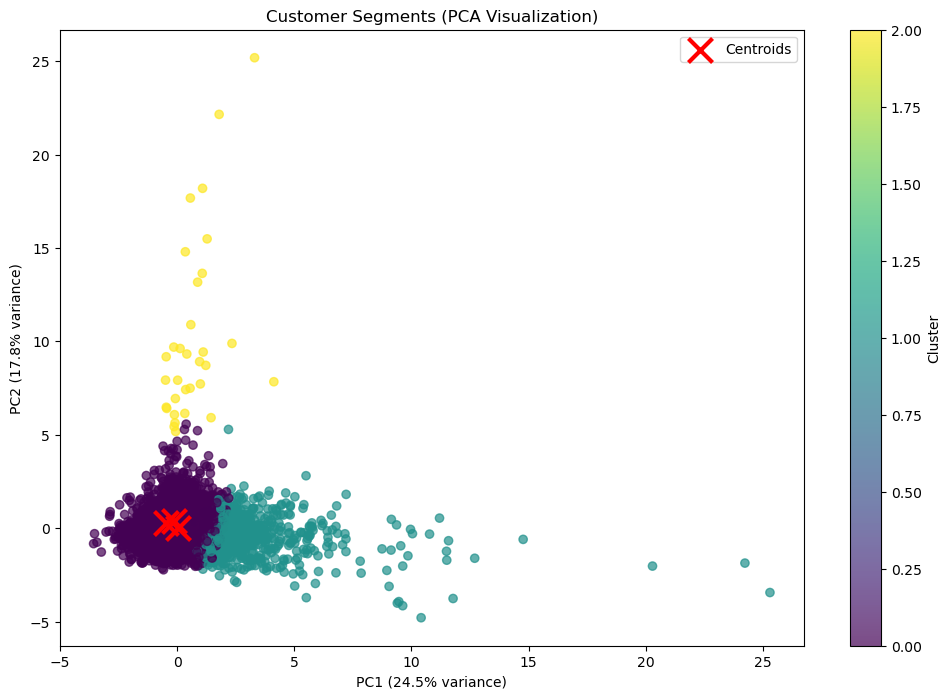

In [20]:
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', alpha=0.7)
plt.scatter(final_kmeans.cluster_centers_[:, 0], final_kmeans.cluster_centers_[:, 1], 
           marker='x', s=300, c='red', linewidth=3, label='Centroids')

plt.title('Customer Segments (PCA Visualization)')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.colorbar(scatter, label='Cluster')
plt.legend()
plt.show()

In [22]:
print("\n=== BUSINESS RECOMMENDATIONS ===")
recommendations = {
    "VIP Customers": "• Exclusive offers\n• Priority support\n• Loyalty rewards",
    "High-Value": "• Premium products\n• Volume discounts\n• Personal account manager",
    "At-Risk": "• Win-back campaigns\n• Special discounts\n• Re-engagement emails", 
    "New/Occasional": "• Onboarding sequence\n• Educational content\n• First-purchase incentives",
    "Regular": "• Cross-sell opportunities\n• Referral programs\n• Seasonal promotions"
}
for rec_type, actions in recommendations.items():
    print(f"\n{rec_type}:\n{actions}")


=== BUSINESS RECOMMENDATIONS ===

VIP Customers:
• Exclusive offers
• Priority support
• Loyalty rewards

High-Value:
• Premium products
• Volume discounts
• Personal account manager

At-Risk:
• Win-back campaigns
• Special discounts
• Re-engagement emails

New/Occasional:
• Onboarding sequence
• Educational content
• First-purchase incentives

Regular:
• Cross-sell opportunities
• Referral programs
• Seasonal promotions
